In [25]:

import numpy as np
import random
from numpy import loadtxt
from scipy.optimize import curve_fit
import os
import matplotlib.pyplot as plt

import scipy.special
from scipy.optimize import fmin
from tqdm import tqdm

from estimate_nc.estimate_nc import estimate_nc, en_per_particle

In [26]:
results = {}
r_0 = 387.6   # https://www.wolframalpha.com/input?i=%28162Dy+mass%29+*+%28mu_0%29+*+%289.93+bohr+magneton%29%5E2+%2F+%284+pi+hbar%5E2%29+%2F+%28bohr+radius%29

# Analyze recipe-7

In [27]:
data = np.loadtxt("./results/critical-atom-numbers/recipe-7-nc/functionals_E_N.dat")
# the header is: a_s  n_c_best_possible_fit  rho_min_x  rho_max_x  alpha  alpha_opt  beta  gamma  min_energy  
# read all data
a_s = data[:,0]
n_c_best_possible_fit = data[:,1]
rho_min_x = data[:,2]
rho_max_x = data[:,3]
alpha = data[:,4]
alpha_opt = data[:,5]
beta = data[:,6]
gamma = data[:,7]

# Take only the data where rho_min_x is smaller than 0.7, and rho_max_x is larger than 2.0
indices = np.where((rho_min_x < 0.7) & (rho_min_x > 0.4) & (rho_max_x > 1.5) & (rho_max_x < 2.5))
a_s = a_s[indices]
n_c_best_possible_fit = n_c_best_possible_fit[indices]
rho_min_x = rho_min_x[indices]
rho_max_x = rho_max_x[indices]
alpha = alpha[indices]
alpha_opt = alpha_opt[indices]
beta = beta[indices]
gamma = gamma[indices]
set(rho_min_x), set(rho_max_x)

({0.5, 0.6}, {1.7, 1.9, 2.1, 2.3})

## Plot $\beta$ vs $a_s$

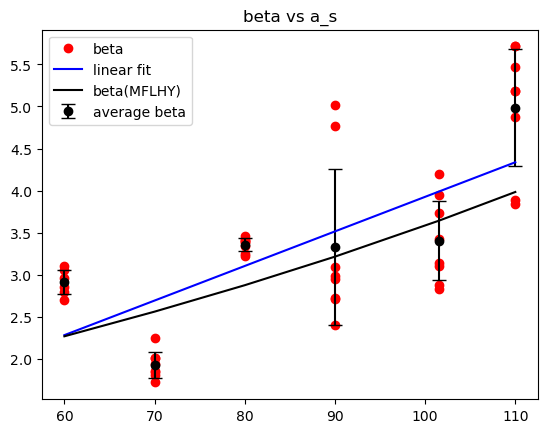

In [28]:
# Plot beta vs a_s
plt.plot(a_s, beta, 'o', label='beta', color='red')
# On the same plot, plot the error bar for each a_s
a_s_unique = np.unique(a_s)
average = np.zeros(len(a_s_unique))
std = np.zeros(len(a_s_unique))
for i in range(len(a_s_unique)):
    average[i] = np.average(beta[a_s==a_s_unique[i]])
    std[i] = np.std(beta[a_s==a_s_unique[i]])
# plot the error bar for each a_s, with larger error bars for a_s with less data points
plt.errorbar(a_s_unique, average, yerr=std, fmt='o', label='average beta', capsize=5, color='black')
# Make a linear fit of the average beta vs a_s
def func_beta(x, a, b):
    return a*x + b
popt_beta, pcov = curve_fit(func_beta, a_s_unique, average)
plt.plot(a_s_unique, func_beta(a_s_unique, *popt_beta), label='linear fit', color='blue')


beta_mflhy = 256*np.sqrt(np.pi)*(a_s_unique/r_0)**(5/2)/15 + 128*np.sqrt(np.pi)*np.sqrt((a_s_unique/r_0))/45
plt.plot(a_s_unique,beta_mflhy, label='beta(MFLHY)', color='black')


plt.title("beta vs a_s")
plt.legend(loc='best')

## Plot $\gamma$ vs $a_s$

<f_gamma(a_s)> 1.721682499999998


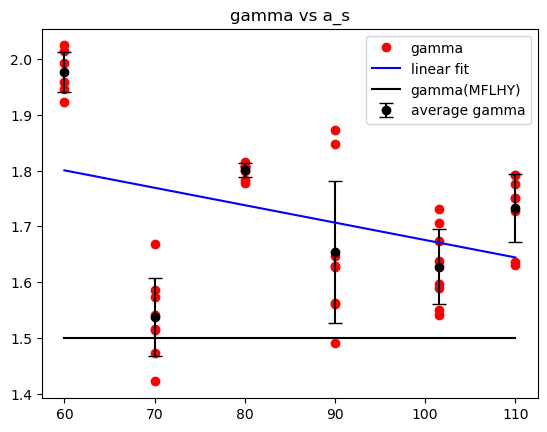

In [29]:
# Plot gamma vs a_s
plt.plot(a_s, gamma, 'o', label='gamma', color='red')
# On the same plot, plot the error bar for each a_s
a_s_unique = np.unique(a_s)
average = np.zeros(len(a_s_unique))
std = np.zeros(len(a_s_unique))
for i in range(len(a_s_unique)):
    average[i] = np.average(gamma[a_s==a_s_unique[i]])
    std[i] = np.std(gamma[a_s==a_s_unique[i]])
# plot the error bar for each a_s, with larger error bars for a_s with less data points
plt.errorbar(a_s_unique, average, yerr=std, fmt='o', label='average gamma', capsize=5, color='black')
# Make a linear fit of the average gamma vs a_s
def func_gamma(x, a, b):
    return a*x + b
popt_gamma, pcov = curve_fit(func_gamma, a_s_unique, average)
plt.plot(a_s_unique, func_gamma(a_s_unique, *popt_gamma), label='linear fit', color='blue')

print("<f_gamma(a_s)>", np.average(func_gamma(a_s_unique, *popt_gamma)))
plt.plot(a_s_unique,[1.5]*len(a_s_unique), label='gamma(MFLHY)', color='black')


plt.title("gamma vs a_s")
plt.legend(loc='best')

## Estimate $n_c$ for each $a_s$ value, using fits


In [30]:
a_s = np.linspace(60, 110, 20)
r_0 = 387.6   # https://www.wolframalpha.com/input?i=%28162Dy+mass%29+*+%28mu_0%29+*+%289.93+bohr+magneton%29%5E2+%2F+%284+pi+hbar%5E2%29+%2F+%28bohr+radius%29
# for each a_s, find the best possible fit for n_c, using the fits func_beta and func_gamma
n_c_best_possible_fit = np.zeros(len(a_s))
for i in tqdm(range(len(a_s))):
    alpha = 2*np.pi*(a_s[i]/r_0) # * (1 - 1 / (3*(a_s / r_0)))
    n_c_best_possible_fit[i] = estimate_nc(alpha,func_beta(a_s[i], *popt_beta), func_gamma(a_s[i], *popt_gamma), based_on="size", verbose=False)[0]


100%|██████████| 20/20 [00:57<00:00,  2.87s/it]


In [31]:
results["recipe-7-using-beta-gamma-fits"] = {"a_s": a_s, "n_c_best_possible_fit": n_c_best_possible_fit}

# Analyze recipe-7-freeze-gamma

In [32]:
data = np.loadtxt("./results/critical-atom-numbers/recipe-7-freeze-gamma/functionals_E_N.dat")
# the header is: a_s  n_c_best_possible_fit  rho_min_x  rho_max_x  alpha  alpha_opt  beta  gamma  min_energy  
# read all data
a_s = data[:,0]
n_c_best_possible_fit = data[:,1]
rho_min_x = data[:,2]
rho_max_x = data[:,3]
beta = data[:,4]

# Take only the data where rho_min_x is smaller than 0.7, and rho_max_x is larger than 2.0
indices = np.where((rho_min_x < 0.7) & (rho_min_x > 0.4) & (rho_max_x > 1.5) & (rho_max_x < 2.5))
a_s = a_s[indices]
n_c_best_possible_fit = n_c_best_possible_fit[indices]
rho_min_x = rho_min_x[indices]
rho_max_x = rho_max_x[indices]
beta = beta[indices]
set(rho_min_x), set(rho_max_x)

({0.5, 0.6}, {1.7, 1.9, 2.1, 2.3})

## Plot $\beta$ vs $a_s$

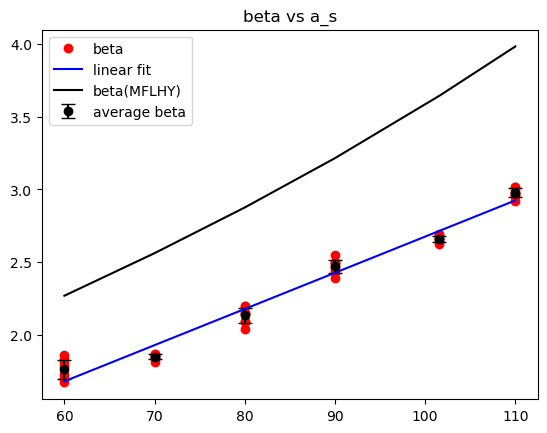

In [33]:
# Plot beta vs a_s
plt.plot(a_s, beta, 'o', label='beta', color='red')
# On the same plot, plot the error bar for each a_s
a_s_unique = np.unique(a_s)
average = np.zeros(len(a_s_unique))
std = np.zeros(len(a_s_unique))
for i in range(len(a_s_unique)):
    average[i] = np.average(beta[a_s==a_s_unique[i]])
    std[i] = np.std(beta[a_s==a_s_unique[i]])
# plot the error bar for each a_s, with larger error bars for a_s with less data points
plt.errorbar(a_s_unique, average, yerr=std, fmt='o', label='average beta', capsize=5, color='black')
# Make a linear fit of the average beta vs a_s
def func_beta(x, a, b):
    return a*x + b
popt_beta, pcov = curve_fit(func_beta, a_s_unique, average)
plt.plot(a_s_unique, func_beta(a_s_unique, *popt_beta), label='linear fit', color='blue')


beta_mflhy = 256*np.sqrt(np.pi)*(a_s_unique/r_0)**(5/2)/15 + 128*np.sqrt(np.pi)*np.sqrt((a_s_unique/r_0))/45
plt.plot(a_s_unique,beta_mflhy, label='beta(MFLHY)', color='black')


plt.title("beta vs a_s")
plt.legend(loc='best')

## Estimate $n_c$ for each $a_s$ value, using fits


In [34]:
a_s = np.linspace(60, 110, 20)
r_0 = 387.6   # https://www.wolframalpha.com/input?i=%28162Dy+mass%29+*+%28mu_0%29+*+%289.93+bohr+magneton%29%5E2+%2F+%284+pi+hbar%5E2%29+%2F+%28bohr+radius%29
# for each a_s, find the best possible fit for n_c, using the fits func_beta and func_gamma
n_c_best_possible_fit = np.zeros(len(a_s))
for i in tqdm(range(len(a_s))):
    alpha = 2*np.pi*(a_s[i]/r_0) # * (1 - 1 / (3*(a_s / r_0)))
    n_c_best_possible_fit[i] = estimate_nc(alpha,func_beta(a_s[i], *popt_beta), func_gamma(a_s[i], *popt_gamma), based_on="size", verbose=False)[0]


100%|██████████| 20/20 [01:03<00:00,  3.16s/it]


In [35]:
results["recipe-7-freeze-gamma-using-beta-gamma-fits"] = {"a_s": a_s, "n_c_best_possible_fit": n_c_best_possible_fit}

# Plot $N_c$

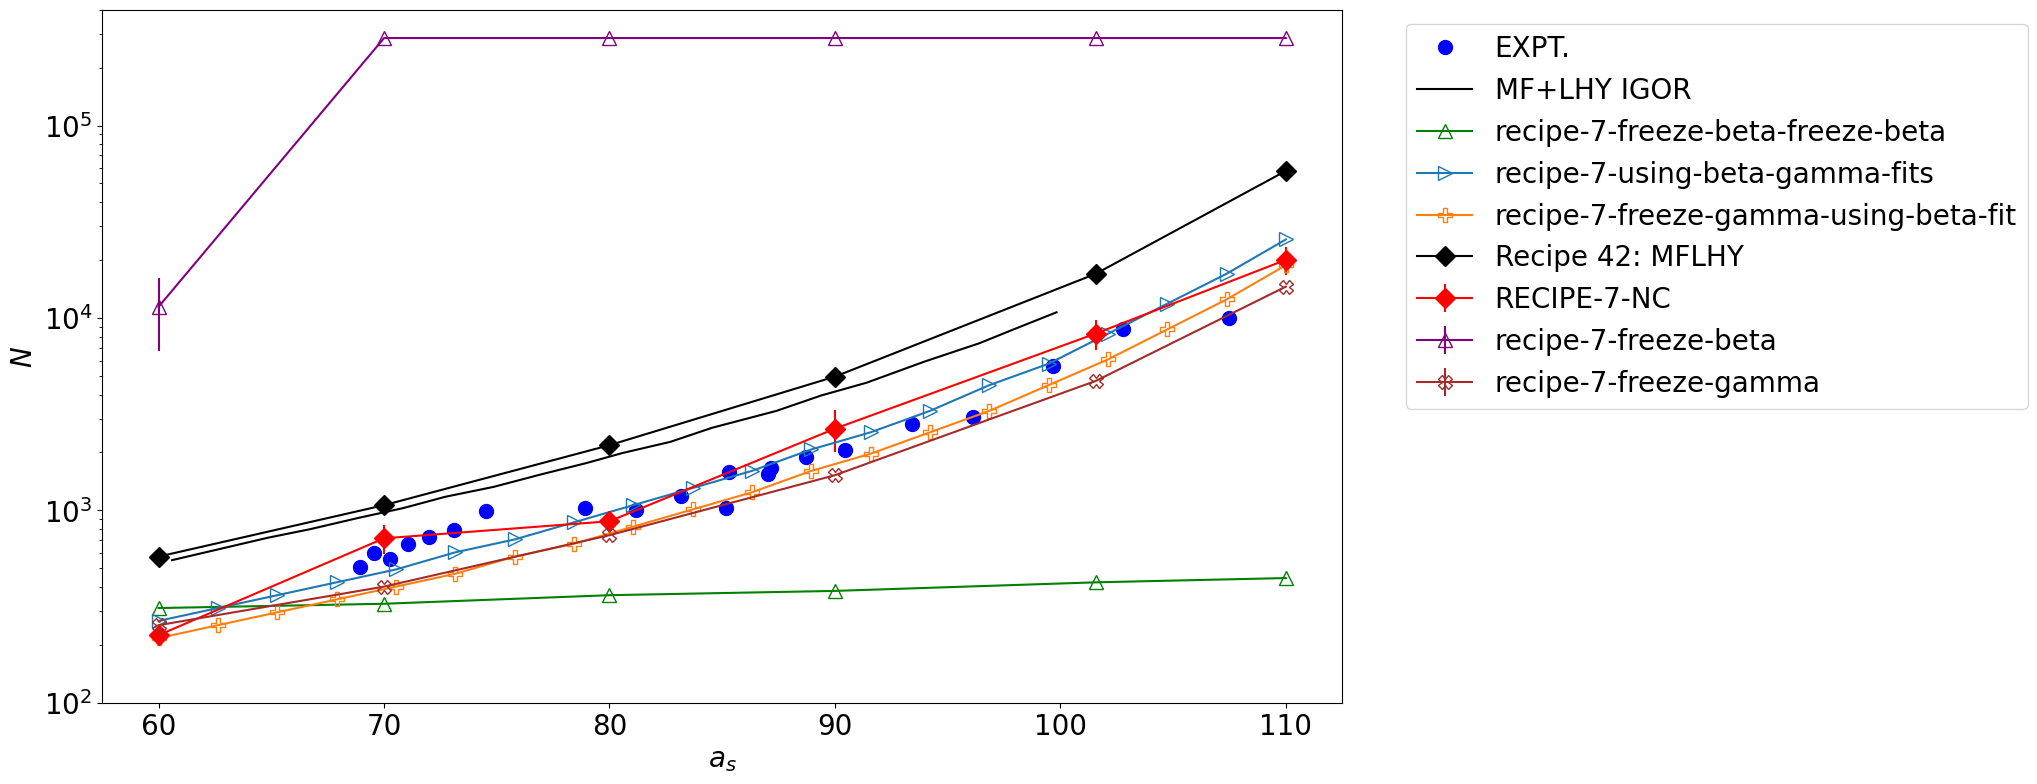

In [39]:


plt.figure(figsize=(16, 9))

def log_func_fit(x, a, b, c):
    return a*x**2 + b*x + c
def func_fit(x, a, b, c):
    return np.exp(log_func_fit(x, a, b, c))
data = np.loadtxt("./experimental-data/combined-critical-atom-number.dat")
sclen_expt = data[:,0]
nc_expt = data[:,1]
popt, pcov = curve_fit(f=log_func_fit, xdata=sclen_expt, ydata=np.log(nc_expt))

plt.plot(sclen_expt, nc_expt, label="EXPT.", ls='', marker='o', color='blue', markersize=10)


mf_data = np.loadtxt("./experimental-data/mean_field_IGOR.dat")
sclen_mf = mf_data[:,0]
nc_mf = mf_data[:,1]
plt.plot(sclen_mf, nc_mf, label="MF+LHY IGOR", color='black', markersize=10)

# load data from file ./results/critical-atom-numbers/recipe-7-nc/functionals_E_N_average_std.dat and plot it
data = np.loadtxt("./results/critical-atom-numbers/recipe-7-nc/functionals_E_N_average_std.dat")
sclen = data[:,0]
nc = data[:,1]
nc_std = data[:,2]
plt.errorbar(sclen, nc, yerr=nc_std, label="RECIPE-7-NC", color='red', ls='-', marker='D', markersize=10)

# # same, but for recipe 8
# data = np.loadtxt("./results/critical-atom-numbers/recipe-8-nc/functionals_E_N_average_std.dat")
# sclen = data[:,0]
# nc = data[:,1]
# nc_std = data[:,2]
# # plot the green error bars, but with the line, with non filled markers
# plt.errorbar(sclen, nc, yerr=nc_std, label="RECIPE-8-NC", color='green', ls='-', marker='^', markersize=10, markerfacecolor='none')


# same, but for recipe 8
# data = np.loadtxt("./results/critical-atom-numbers/recipe-8-nc-approach-2/functionals_E_N_average_std.dat")
# sclen = data[:,0]
# nc = data[:,1]
# nc_std = data[:,2]
# # plot the green error bars, but with the line, with non filled markers
# plt.errorbar(sclen, nc, yerr=nc_std, label="recipe-8-nc-approach-2", color='purple', ls='-', marker='^', markersize=10, markerfacecolor='none')



data = np.loadtxt("./results/critical-atom-numbers/recipe-7-freeze-beta/functionals_E_N_average_std.dat")
sclen = data[:,0]
nc = data[:,1]
nc_std = data[:,2]
# plot the green error bars, but with the line, with non filled markers
plt.errorbar(sclen, nc, yerr=nc_std, label="recipe-7-freeze-beta", color='purple', ls='-', marker='^', markersize=10, markerfacecolor='none')


data = np.loadtxt("./results/critical-atom-numbers/recipe-7-freeze-gamma/functionals_E_N_average_std.dat")
sclen = data[:,0]
nc = data[:,1]
nc_std = data[:,2]
# plot the green error bars, but with the line, with non filled markers
plt.errorbar(sclen, nc, yerr=nc_std, label="recipe-7-freeze-gamma", color='brown', ls='-', marker='X', markersize=10, markerfacecolor='none')


data = np.loadtxt("results/critical-atom-numbers/recipe-7-freeze-beta-freeze-gamma/functionals_E_N.dat")
sclen = data[:,0]
nc = data[:,1]
# sort the data by sclen
sclen, nc = zip(*sorted(zip(sclen, nc)))
# plot the green error bars, but with the line, with non filled markers
plt.plot(sclen, nc, label="recipe-7-freeze-beta-freeze-beta", color='green', ls='-', marker='^', markersize=10, markerfacecolor='none')


plt.plot(results["recipe-7-using-beta-gamma-fits"]["a_s"], results["recipe-7-using-beta-gamma-fits"]["n_c_best_possible_fit"], label="recipe-7-using-beta-gamma-fits", ls='-', marker='>', markersize=10, markerfacecolor='none')


plt.plot(results["recipe-7-freeze-gamma-using-beta-gamma-fits"]["a_s"], results["recipe-7-freeze-gamma-using-beta-gamma-fits"]["n_c_best_possible_fit"], label="recipe-7-freeze-gamma-using-beta-fit", ls='-', marker='P', markersize=10, markerfacecolor='none')


# Open the output file for writing
# data = np.loadtxt("results/critical-atom-numbers/recipe-7-nc/functionals_E_N_2nd_approach.dat")
# # the header is as follows: a_s <n_c>  err(n_c)  <beta>  err(beta) <gamma>  \n"). Read the data and plot
# sclen = data[:,0]
# nc = data[:,1]
# nc_std = data[:,2]
# plt.errorbar(sclen, nc, yerr=nc_std, label="RECIPE-7-NC-2ND-APPROACH", color='green', ls='-', marker='o', markersize=10)

data = np.loadtxt("./results/critical-atom-numbers/recipe-42-nc/functionals_E_N.dat")
sclen = data[:,0]
nc = data[:,1]
plt.plot(sclen, nc, label="Recipe 42: MFLHY", color='black', marker='D', ls='-', markersize=10)



plt.xlabel(r'$a_s$', fontsize=20)
plt.ylabel(r'$N$', fontsize=20)
plt.legend(loc = "best", bbox_to_anchor=(1.04, 1), fontsize=20)


plt.yscale('log')
plt.ylim(100, 400000)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Save the figure into plots folder
plt.savefig(f"plots/critical-atom-number.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"plots/critical-atom-number.png", bbox_inches='tight', dpi=300)
